In [1]:
# Instalação de dependências (execute apenas uma vez)
!pip -q install --upgrade pip
!pip -q install opencv-python matplotlib pillow tqdm pycocotools scikit-learn torch torchvision torchaudio timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00


In [2]:
import os
import json as json_lib
import random
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Fix seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Paths and constants
PROJ_DIR  = Path('taco_pipeline')
DATA_DIR  = PROJ_DIR / 'datasets'
OUT_DIR   = PROJ_DIR / 'outputs'
TACO_ZIP  = DATA_DIR / 'TACO.zip'
TACO_URL  = 'https://zenodo.org/records/3354286/files/TACO.zip?download=1'
CROPS_DIR = PROJ_DIR / 'taco_crops'

IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]


In [3]:
# -----------------------------------------------------------------------------
# Funções utilitárias para download e extração
# -----------------------------------------------------------------------------

def download_and_extract_taco(data_dir: Path, zip_path: Path, url: str) -> Path:
    """Baixa e extrai o dataset TACO. Retorna o caminho para a pasta extraída."""
    data_dir.mkdir(parents=True, exist_ok=True)
    if not zip_path.exists():
        print(f"[INFO] Baixando TACO em {zip_path} ...")
        os.system(f'wget -q "{url}" -O "{zip_path}"')
    else:
        print("[INFO] Arquivo zip do TACO já existe. Pulando download.")
    extract_dir = data_dir / 'TACO'
    if not extract_dir.exists():
        print("[INFO] Extraindo conteúdo do zip ...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extract_dir)
        print("[INFO] Extração concluída.")
    else:
        print("[INFO] Pasta extraída já existe. Pulando extração.")
    return extract_dir

# -----------------------------------------------------------------------------
# Carregamento das anotações COCO
# -----------------------------------------------------------------------------

def load_coco_annotations(taco_dir: Path) -> dict:
    """Localiza e carrega o arquivo annotations.json dentro de taco_dir."""
    ann_path = None
    for p in taco_dir.rglob('annotations.json'):
        ann_path = p
        break
    assert ann_path is not None, "annotations.json não encontrado no diretório fornecido"
    with open(ann_path, 'r', encoding='utf-8') as f:
        coco = json_lib.load(f)
    return coco


[INFO] Baixando TACO em taco_pipeline/datasets/TACO.zip ...
[INFO] Extraindo conteúdo do zip ...
[INFO] Extração concluída.
[INFO] Gerando crops e salvando DataFrame...


Gerando crops:   0%|          | 0/2152 [00:00<?, ?it/s]

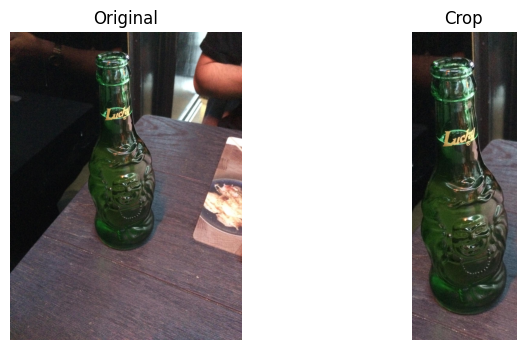

Gerando crops:   0%|          | 1/2152 [00:00<25:38,  1.40it/s]

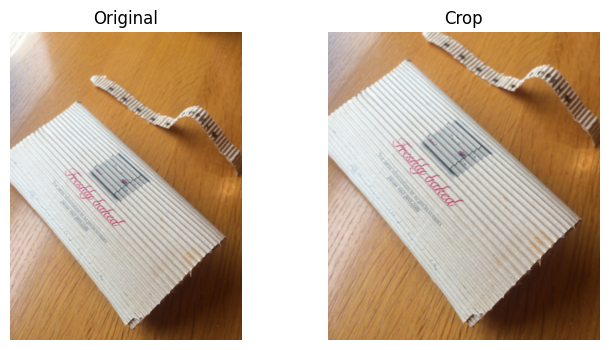

Gerando crops:   0%|          | 2/2152 [00:01<28:17,  1.27it/s]

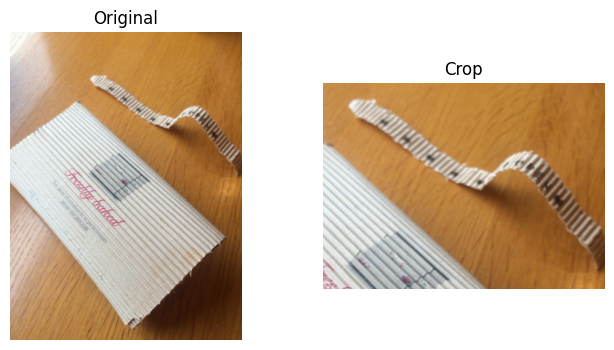

Gerando crops: 100%|██████████| 2152/2152 [03:15<00:00, 11.03it/s]

Total de crops gerados: 2152


In [4]:
# -----------------------------------------------------------------------------
# Geração de crops a partir das segmentações
# -----------------------------------------------------------------------------

def clamp(val, lo, hi):
    return max(lo, min(hi, val))

def create_crops_with_segmentation(coco: dict, taco_dir: Path, output_dir: Path, margin: float = 0.1, show_samples: int = 0):
    """
    Percorre anotações COCO e cria um crop por instância usando a máscara de segmentação.
    - margin: percentual de aumento da bounding box (ex.: 0.1 amplia 10%)
    - show_samples: número de exemplos (imagem original x crop) a serem exibidos
    Retorna um DataFrame com colunas ['path','class_name','class_id'].
    """
    images = {img['id']: img for img in coco['images']}
    categories = {c['id']: c for c in coco['categories']}
    output_dir.mkdir(parents=True, exist_ok=True)
    records = []
    sample_count = 0
    for ann in tqdm(coco['annotations'], desc='Gerando crops'):
        img_id = ann['image_id']
        img_info = images[img_id]
        img_rel_path = img_info['file_name']
        img_path = next(iter(taco_dir.glob(f"**/{img_rel_path}")), None)
        if img_path is None:
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        h, w = img.shape[:2]
        segs = ann.get('segmentation', [])
        if not segs:
            # fallback: usa bbox
            x, y, bw, bh = ann['bbox']
            x1 = clamp(int(x), 0, w-1)
            y1 = clamp(int(y), 0, h-1)
            x2 = clamp(int(x + bw), 1, w)
            y2 = clamp(int(y + bh), 1, h)
            mask = np.zeros((h, w), dtype=np.uint8)
            mask[y1:y2, x1:x2] = 255
        else:
            mask = np.zeros((h, w), dtype=np.uint8)
            for seg in segs:
                pts = np.array(seg, dtype=np.float32).reshape(-1, 2)
                pts = pts.astype(np.int32)
                cv2.fillPoly(mask, [pts], color=255)
        ys, xs = np.where(mask > 0)
        if len(xs) == 0 or len(ys) == 0:
            continue
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        dx = int((x_max - x_min) * margin)
        dy = int((y_max - y_min) * margin)
        x1 = clamp(x_min - dx, 0, w-1)
        y1 = clamp(y_min - dy, 0, h-1)
        x2 = clamp(x_max + dx, 1, w)
        y2 = clamp(y_max + dy, 1, h)
        crop = img[y1:y2, x1:x2]
        cat_id = ann['category_id']
        cat_name = categories[cat_id]['name']
        class_dir = output_dir / cat_name
        class_dir.mkdir(parents=True, exist_ok=True)
        crop_filename = f"{Path(img_rel_path).stem}_{ann['id']}.jpg"
        crop_path = class_dir / crop_filename
        cv2.imwrite(str(crop_path), crop)
        records.append({'path': str(crop_path), 'class_name': cat_name, 'class_id': cat_id})
        # visualização opcional
        if show_samples > 0 and sample_count < show_samples:
            sample_count += 1
            fig, ax = plt.subplots(1, 2, figsize=(8,4))
            ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[0].set_title('Original')
            ax[0].axis('off')
            ax[1].imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            ax[1].set_title('Crop')
            ax[1].axis('off')
            plt.show()
    df = pd.DataFrame(records)
    # reindexa classes para serem sequenciais a partir de 0
    class_map = {cid: i for i, cid in enumerate(sorted(df['class_id'].unique()))}
    df['class_id'] = df['class_id'].map(class_map)
    return df

# Tenta carregar os crops de disco ou gerar se não existirem
crops_df_path = CROPS_DIR / 'crops_dataframe.csv'
if CROPS_DIR.exists() and any(CROPS_DIR.iterdir()) and crops_df_path.exists():
    print("[INFO] Pasta de crops e arquivo CSV já existem. Carregando DataFrame...")
    df_crops = pd.read_csv(crops_df_path)
    class_map = {cid: i for i, cid in enumerate(sorted(df_crops['class_id'].unique()))}
    df_crops['class_id'] = df_crops['class_id'].map(class_map)
    print(f"Total de crops carregados: {len(df_crops)}")
else:
    taco_dir = download_and_extract_taco(DATA_DIR, TACO_ZIP, TACO_URL)
    coco = load_coco_annotations(taco_dir)
    print("[INFO] Gerando crops e salvando DataFrame...")
    df_crops = create_crops_with_segmentation(coco, taco_dir, CROPS_DIR, margin=0.1, show_samples=3)
    df_crops.to_csv(crops_df_path, index=False)
    print(f"Total de crops gerados: {len(df_crops)}")


In [5]:
# -----------------------------------------------------------------------------
# Divisão estratificada em treino/validação/teste
# -----------------------------------------------------------------------------

def stratified_split(df: pd.DataFrame, test_size: float = 0.15, val_size: float = 0.15, min_samples_per_class: int = 2):
    counts = df['class_name'].value_counts()
    rare = counts[counts < min_samples_per_class]
    if len(rare) > 0:
        df = df[~df['class_name'].isin(rare.index)].reset_index(drop=True)
    class_map = {c: i for i, c in enumerate(sorted(df['class_name'].unique()))}
    df['class_id'] = df['class_name'].map(class_map)
    df_trainval, df_test = train_test_split(df, test_size=test_size, stratify=df['class_id'], random_state=SEED)
    df_train, df_val = train_test_split(df_trainval, test_size=val_size/(1-test_size), stratify=df_trainval['class_id'], random_state=SEED)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

# Executa a divisão
df_train, df_val, df_test = stratified_split(df_crops, test_size=0.15, val_size=0.15, min_samples_per_class=2)
print(f"Tamanho dos conjuntos - Treino: {len(df_train)}, Validação: {len(df_val)}, Teste: {len(df_test)}")


Tamanho dos conjuntos - Treino: 1503, Validação: 323, Teste: 323


In [6]:
# -----------------------------------------------------------------------------
# Data augmentation e normalização
# -----------------------------------------------------------------------------

def get_transforms(train: bool = True):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(), # Apply ToTensor() before transforms that expect tensors
            transforms.RandomErasing(p=0.5),
            transforms.Normalize(mean=MEAN, std=STD),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
        ])

# Criação dos datasets e dataloaders
class ImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms_fn):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms_fn
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.cvtColor(cv2.imread(row['path']), cv2.COLOR_BGR2RGB)
        from PIL import Image as PILImage
        pil = PILImage.fromarray(img)
        img_t = self.transforms(pil)
        label = torch.tensor(row['class_id'], dtype=torch.long)
        return img_t, label

# Cria DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2
train_ds = ImageDataset(df_train, get_transforms(True))
val_ds   = ImageDataset(df_val,   get_transforms(False))
test_ds  = ImageDataset(df_test,  get_transforms(False))

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print("Dataloaders criados com sucesso.")

Dataloaders criados com sucesso.


In [7]:
# -----------------------------------------------------------------------------
# Construção do modelo
# -----------------------------------------------------------------------------

def build_model(model_name: str, num_classes: int, dropout_p: float = 0.2):
    if model_name == 'resnet50':
        model = timm.create_model('resnet50', pretrained=True)
        n_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(n_features, num_classes)
        )
    elif model_name == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=True)
        n_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(n_features, num_classes)
        )
    else:
        raise ValueError(f"Modelo não suportado: {model_name}")
    return model

# MODEL_TYPE = 'resnet50'  # ajuste para 'efficientnet_b0' se desejar
# model = build_model(MODEL_TYPE, num_classes=df_crops['class_id'].nunique(), dropout_p=0.2)
# print(f"Modelo {MODEL_TYPE} criado com {df_crops['class_id'].nunique()} classes.")


In [8]:
# -----------------------------------------------------------------------------
# Função de treinamento do modelo
# -----------------------------------------------------------------------------

def train_model(model, train_loader, val_loader, epochs: int = 50, lr: float = 3e-4, weight_decay: float = 1e-4, patience: int = 8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
    best_val_loss = float('inf')
    best_weights = None
    patience_counter = 0
    history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, epochs+1):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                outputs = model(xb)
                loss = criterion(outputs, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            _, preds = torch.max(outputs, 1)
            total += yb.size(0)
            running_loss += loss.item() * yb.size(0)
            running_correct += (preds == yb).sum().item()
        train_loss = running_loss / total
        train_acc  = running_correct / total
        # Validação
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                _, preds = torch.max(outputs, 1)
                val_total += yb.size(0)
                val_loss += loss.item() * yb.size(0)
                val_correct += (preds == yb).sum().item()
        val_loss /= val_total
        val_acc  = val_correct / val_total
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch}/{epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[Early Stopping] early stopped after {epoch} epochs.")
                break
    if best_weights is not None:
        model.load_state_dict(best_weights)
    return model, history

# O treinamento será executado posteriormente em um loop de comparação de modelos
# epochs = 50  # substituído no loop de comparação
# trained_model, history = train_model(model, train_dl, val_dl, epochs=epochs, lr=3e-4, weight_decay=1e-4, patience=8)


In [9]:
# -----------------------------------------------------------------------------
# Avaliação no conjunto de teste
# -----------------------------------------------------------------------------

@torch.no_grad()
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)
    y_true, y_pred = [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, 1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(yb.numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    print(f"[TEST] Acurácia = {acc:.4f}, F1 (ponderado) = {f1:.4f}")
    return y_true, y_pred, report, cm

# A avaliação será executada posteriormente no loop de comparação de modelos
# y_true, y_pred, report, cm = evaluate_model(trained_model, test_dl)


In [10]:
# -----------------------------------------------------------------------------
# Plot das curvas de perda e acurácia durante o treinamento
# -----------------------------------------------------------------------------

def plot_training_history(history: dict):
    epochs = history['epoch']
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Treino')
    plt.plot(epochs, history['val_loss'], label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.title('Perda durante o treinamento')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Treino')
    plt.plot(epochs, history['val_acc'], label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Acurácia durante o treinamento')
    plt.legend()
    plt.show()

# O histórico será plotado para cada modelo dentro do loop de comparação
# plot_training_history(history)


In [11]:
# -----------------------------------------------------------------------------
# Plot da matriz de confusão
# -----------------------------------------------------------------------------

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", va='center', ha='center', color='red')
    plt.show()

class_names = sorted(df_crops['class_name'].unique())
# plot_confusion_matrix(cm, class_names)


In [12]:
# -----------------------------------------------------------------------------
# Exibir amostras de predições
# -----------------------------------------------------------------------------

def show_sample_predictions(model, dataset: ImageDataset, idx_to_class: dict, n_samples: int = 20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)
    indices = np.random.choice(len(dataset), size=min(n_samples, len(dataset)), replace=False)
    cols = 3
    rows = int(np.ceil(len(indices) / cols))
    plt.figure(figsize=(12, 4 * rows))
    for i, idx in enumerate(indices):
        img, true_label = dataset[idx]
        with torch.no_grad():
            inputs = img.unsqueeze(0).to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, 1).cpu().item()
        img_np = img.permute(1,2,0).numpy()
        img_np = (img_np * np.array(STD) + np.array(MEAN)).clip(0,1)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_np)
        plt.title(f"Real: {idx_to_class[int(true_label)]}\nPredito: {idx_to_class[int(pred)]}")
        plt.axis('off')
    plt.show()

idx_to_class = {v: k for k, v in df_train[['class_name','class_id']].drop_duplicates().set_index('class_name')['class_id'].to_dict().items()}
# show_sample_predictions(trained_model, test_ds, idx_to_class, n_samples=6)

======= Treinando e avaliando modelo: resnet50 =======


/tmp/ipython-input-3156854585.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-3156854585.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
/tmp/ipython-input-3156854585.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 1/50 - Train loss: 3.4846, Train acc: 0.1377, Val loss: 3.2679, Val acc: 0.2198
Epoch 2/50 - Train loss: 2.9803, Train acc: 0.1936, Val loss: 2.9003, Val acc: 0.2693
Epoch 3/50 - Train loss: 2.7129, Train acc: 0.2841, Val loss: 2.6109, Val acc: 0.3034
Epoch 4/50 - Train loss: 2.4342, Train acc: 0.3613, Val loss: 2.3435, Val acc: 0.4087
Epoch 5/50 - Train loss: 2.1425, Train acc: 0.4391, Val loss: 2.0865, Val acc: 0.4520
Epoch 6/50 - Train loss: 1.8618, Train acc: 0.4930, Val loss: 1.9443, Val acc: 0.4799
Epoch 7/50 - Train loss: 1.6534, Train acc: 0.5476, Val loss: 1.8248, Val acc: 0.5077
Epoch 8/50 - Train loss: 1.4486, Train acc: 0.5822, Val loss: 1.7608, Val acc: 0.5232
Epoch 9/50 - Train loss: 1.2806, Train acc: 0.6427, Val loss: 1.6709, Val acc: 0.5480
Epoch 10/50 - Train loss: 1.1550, Train acc: 0.6680, Val loss: 1.6800, Val acc: 0.5511
Epoch 11/50 - Train loss: 1.0225, Train acc: 0.7159, Val loss: 1.5943, Val acc: 0.5573
Epoch 12/50 - Train loss: 0.8893, Train acc: 0.7458,

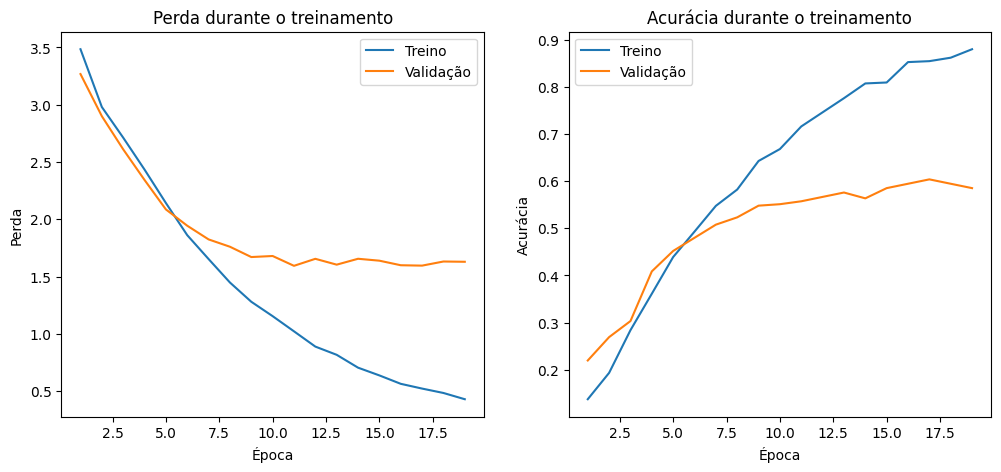

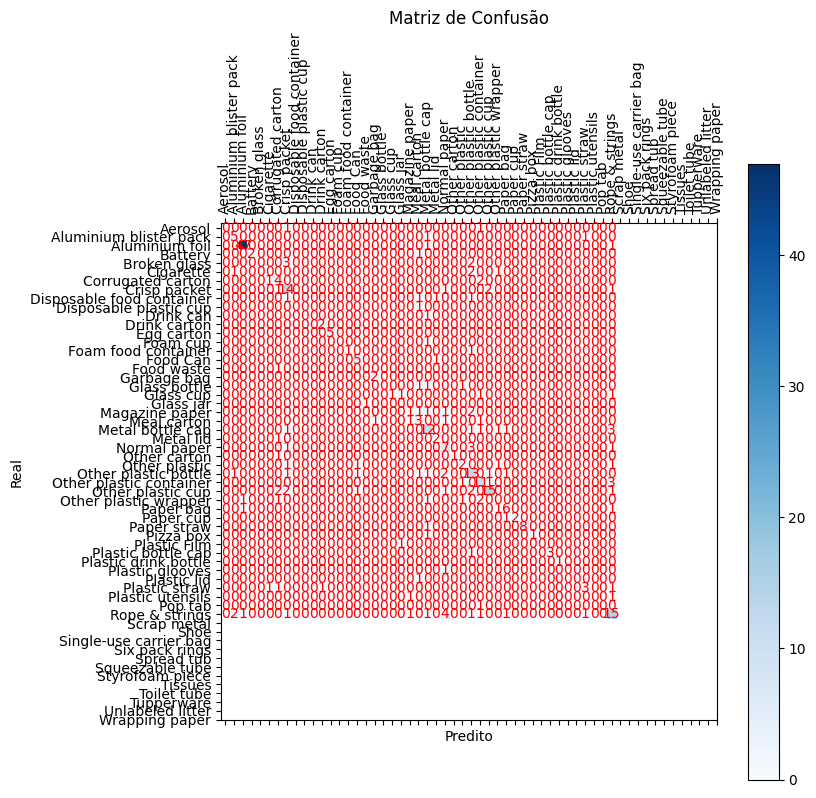

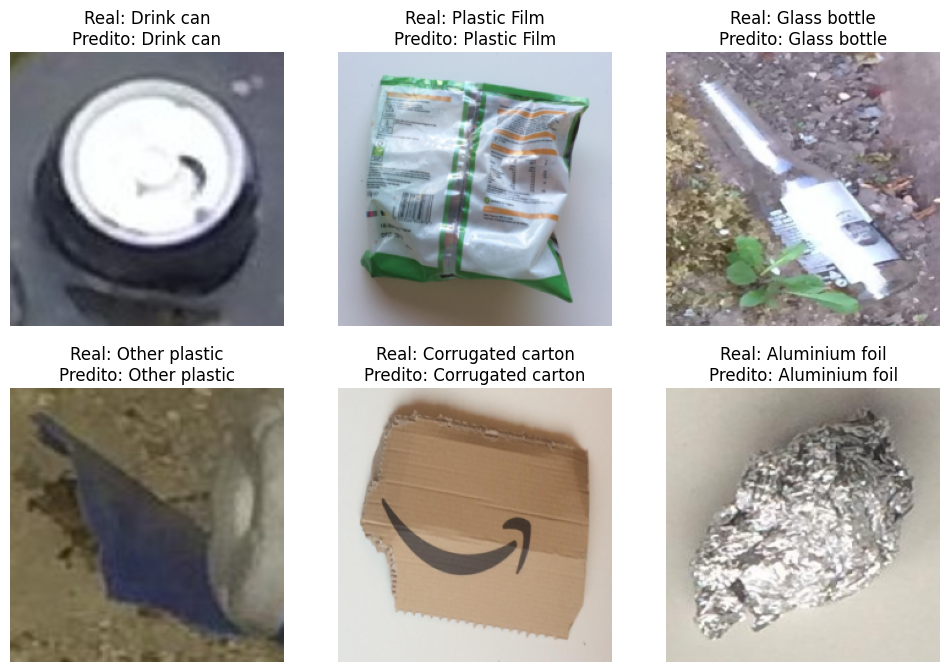

======= Treinando e avaliando modelo: efficientnet_b0 =======


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-3156854585.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-3156854585.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
/tmp/ipython-input-3156854585.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 1/50 - Train loss: 3.0715, Train acc: 0.2788, Val loss: 2.3766, Val acc: 0.4149
Epoch 2/50 - Train loss: 2.0161, Train acc: 0.4757, Val loss: 1.9014, Val acc: 0.5015
Epoch 3/50 - Train loss: 1.4851, Train acc: 0.5975, Val loss: 1.6536, Val acc: 0.5728
Epoch 4/50 - Train loss: 1.1082, Train acc: 0.6993, Val loss: 1.5579, Val acc: 0.5820
Epoch 5/50 - Train loss: 0.8593, Train acc: 0.7711, Val loss: 1.5708, Val acc: 0.5697
Epoch 6/50 - Train loss: 0.6517, Train acc: 0.8377, Val loss: 1.4990, Val acc: 0.5851
Epoch 7/50 - Train loss: 0.5019, Train acc: 0.8749, Val loss: 1.5282, Val acc: 0.6037
Epoch 8/50 - Train loss: 0.3832, Train acc: 0.9115, Val loss: 1.6002, Val acc: 0.5820
Epoch 9/50 - Train loss: 0.2958, Train acc: 0.9321, Val loss: 1.6004, Val acc: 0.5944
Epoch 10/50 - Train loss: 0.2537, Train acc: 0.9361, Val loss: 1.6737, Val acc: 0.5851
Epoch 11/50 - Train loss: 0.2237, Train acc: 0.9468, Val loss: 1.7655, Val acc: 0.5542
Epoch 12/50 - Train loss: 0.1867, Train acc: 0.9587,

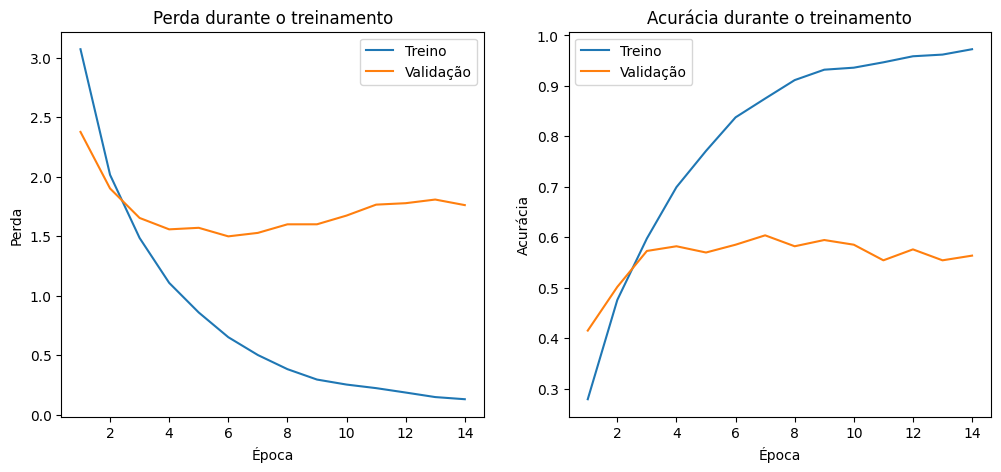

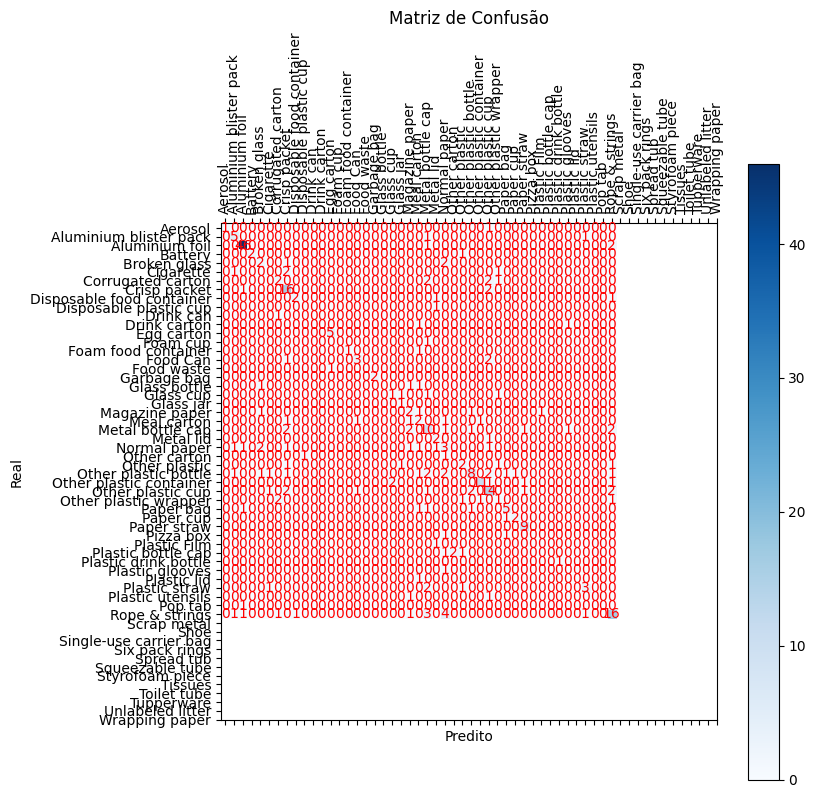

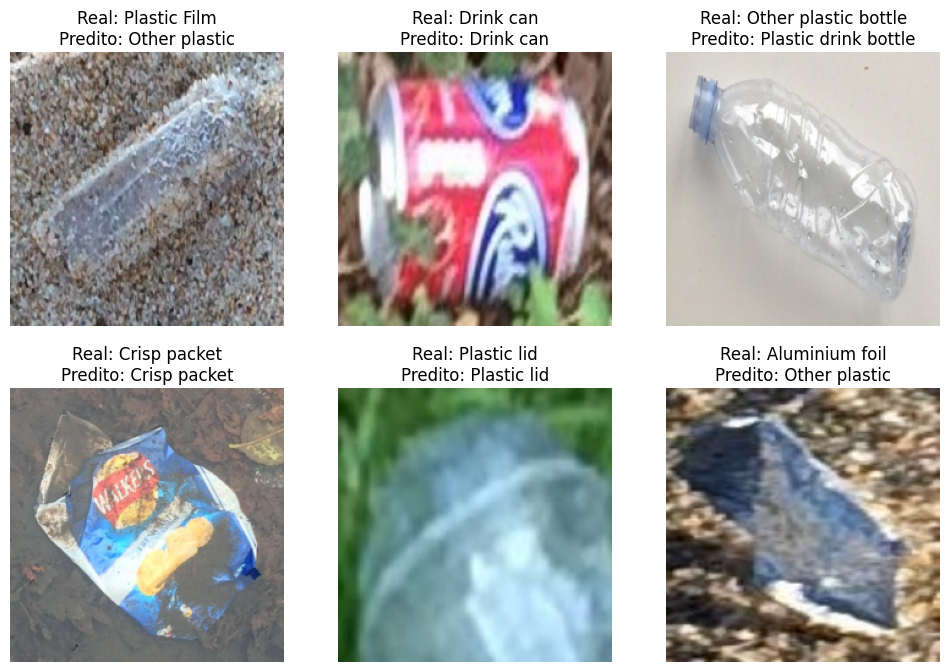

======= Treinando e avaliando modelo: densenet121 =======


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

/tmp/ipython-input-3156854585.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
/tmp/ipython-input-3156854585.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-3156854585.py:41: FutureWarning: `torch.cuda.a

Epoch 1/50 - Train loss: 3.1305, Train acc: 0.2216, Val loss: 2.5686, Val acc: 0.3591
Epoch 2/50 - Train loss: 2.2882, Train acc: 0.4112, Val loss: 2.1094, Val acc: 0.4706
Epoch 3/50 - Train loss: 1.8674, Train acc: 0.5143, Val loss: 1.9653, Val acc: 0.4675
Epoch 4/50 - Train loss: 1.4952, Train acc: 0.5961, Val loss: 1.7811, Val acc: 0.5046
Epoch 5/50 - Train loss: 1.2251, Train acc: 0.6707, Val loss: 1.7282, Val acc: 0.5418
Epoch 6/50 - Train loss: 1.0599, Train acc: 0.7212, Val loss: 1.6801, Val acc: 0.5480
Epoch 7/50 - Train loss: 0.8497, Train acc: 0.7725, Val loss: 1.6271, Val acc: 0.5573
Epoch 8/50 - Train loss: 0.7181, Train acc: 0.8064, Val loss: 1.6454, Val acc: 0.5666
Epoch 9/50 - Train loss: 0.6028, Train acc: 0.8397, Val loss: 1.6312, Val acc: 0.5728
Epoch 10/50 - Train loss: 0.4794, Train acc: 0.8796, Val loss: 1.6389, Val acc: 0.5697
Epoch 11/50 - Train loss: 0.4381, Train acc: 0.8896, Val loss: 1.5694, Val acc: 0.5789
Epoch 12/50 - Train loss: 0.3598, Train acc: 0.9182,

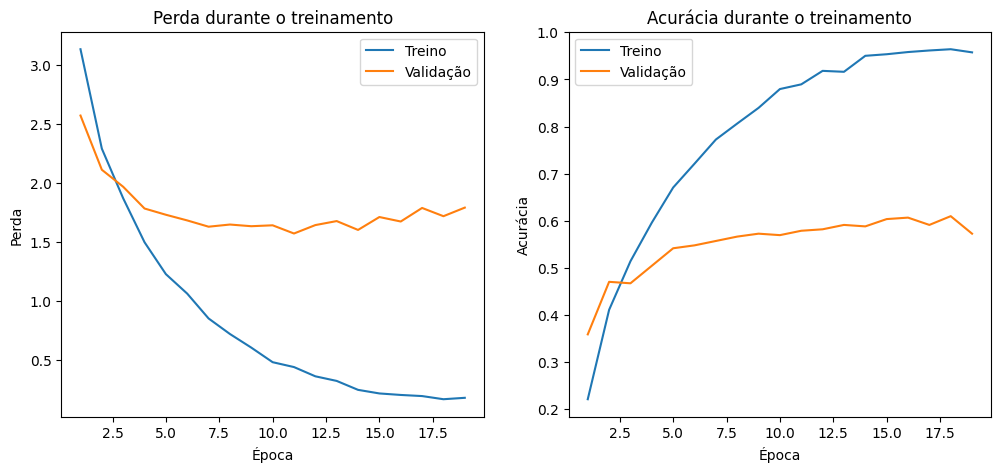

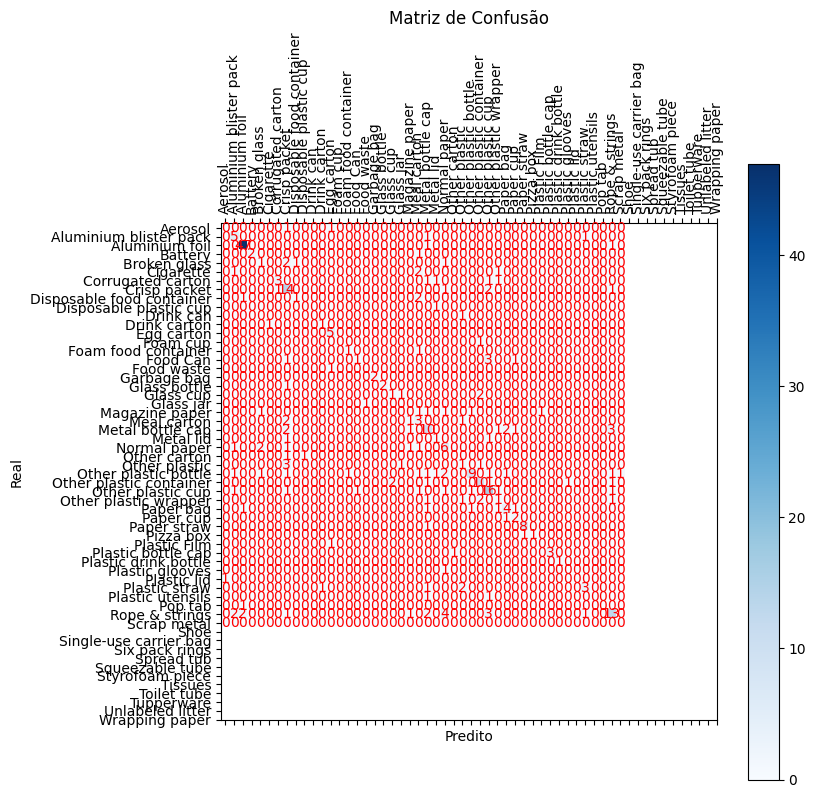

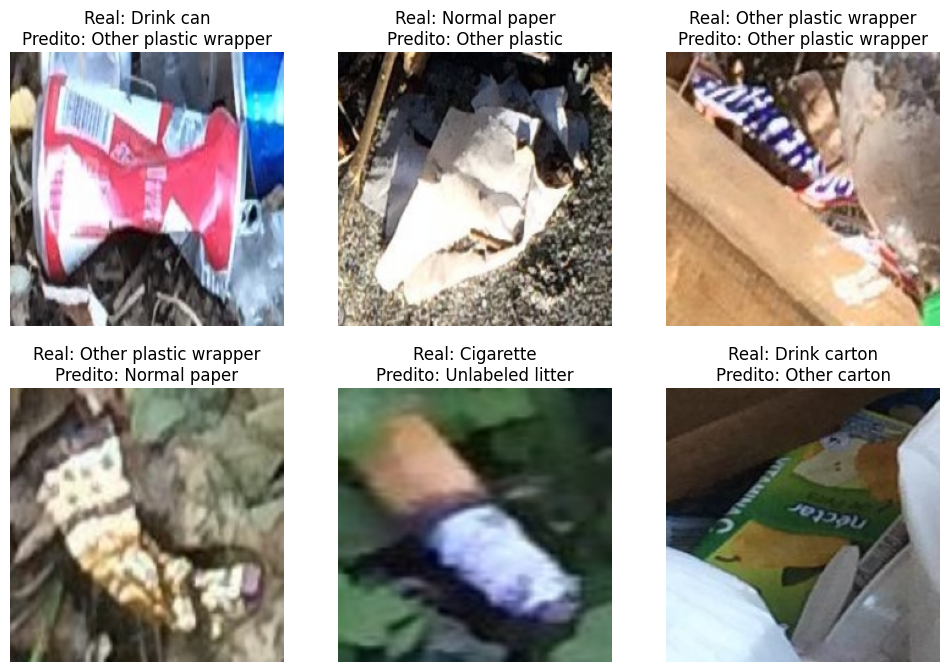

Tabela de métricas de cada modelo:


Modelo  Acurácia        F1
0         resnet50  0.600619  0.579528
1  efficientnet_b0  0.557276  0.543404
2      densenet121  0.551084  0.540275

Amostra de predições para o modelo resnet50:


Real  Predito             Classe_Real          Classe_Predita
0    38       38           Plastic straw           Plastic straw
1    52       52        Unlabeled litter        Unlabeled litter
2    35       33    Plastic drink bottle            Plastic Film
3    38       37           Plastic straw             Plastic lid
4    30       30               Paper cup               Paper cup
5    49       24                 Tissues            Normal paper
6     4        4               Cigarette               Cigarette
7     8        8  Disposable plastic cup  Disposable plastic cup
8    40       40                 Pop tab                 Pop tab
9    26       26           Other plastic           Other plastic

Amostra de predições para o modelo efficientnet_b0:


Real  Predito             Classe_Real        Classe_Predita
0    38       38           Plastic straw         Plastic straw
1    52       52        Unlabeled litter      Unlabeled litter
2    35       35    Plastic drink bottle  Plastic drink bottle
3    38       25           Plastic straw          Other carton
4    30       37               Paper cup           Plastic lid
5    49       24                 Tissues          Normal paper
6     4        4               Cigarette             Cigarette
7     8       35  Disposable plastic cup  Plastic drink bottle
8    40       40                 Pop tab               Pop tab
9    26       26           Other plastic         Other plastic

Amostra de predições para o modelo densenet121:


Real  Predito             Classe_Real        Classe_Predita
0    38       38           Plastic straw         Plastic straw
1    52       52        Unlabeled litter      Unlabeled litter
2    35       35    Plastic drink bottle  Plastic drink bottle
3    38       37           Plastic straw           Plastic lid
4    30       30               Paper cup             Paper cup
5    49       26                 Tissues         Other plastic
6     4        4               Cigarette             Cigarette
7     8       35  Disposable plastic cup  Plastic drink bottle
8    40       40                 Pop tab               Pop tab
9    26       26           Other plastic         Other plastic

In [15]:
# -----------------------------------------------------------------------------
# Loop para treinar, avaliar e comparar múltiplos modelos
# Este código percorre diferentes arquiteturas (resnet50, efficientnet_b0 e densenet121),
# treina cada uma, avalia no conjunto de teste e exibe métricas e amostras de predição.
# Ajuste o número de épocas conforme necessário para treinos mais longos.

from IPython.display import display

# Função estendida para construir modelos adicionais
def build_model_extended(name, num_classes, dropout_p=0.2):
    # Constrói um modelo a partir do nome especificado.
    # Usa build_model para modelos já suportados (resnet50, efficientnet_b0).
    # Para densenet121, cria o modelo manualmente.
    if name in ['resnet50', 'efficientnet_b0']:
        return build_model(name, num_classes, dropout_p)
    elif name == 'densenet121':
        model = timm.create_model('densenet121', pretrained=True)
        # Ajusta a última camada dependendo do atributo disponível
        if hasattr(model, 'classifier'):
            n_features = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Dropout(p=dropout_p),
                nn.Linear(n_features, num_classes)
            )
        else:
            n_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(p=dropout_p),
                nn.Linear(n_features, num_classes)
            )
        return model
    else:
        raise ValueError(f'Modelo não suportado: {name}')

# Lista de modelos a serem comparados
model_names = ['resnet50', 'efficientnet_b0', 'densenet121']

# Estruturas para armazenar resultados, modelos treinados, históricos e predições
results = []
models_trained = {}
histories = {}
predictions_df = {}

# Número de classes (usamos idx_to_class criado anteriormente)
num_classes = len(idx_to_class)

# Ajuste o número de épocas para treinos mais longos ou rápidos
num_epochs = 50

for name in model_names:
    print(f"======= Treinando e avaliando modelo: {name} =======")
    model_i = build_model_extended(name, num_classes, dropout_p=0.2)
    trained_model_i, history_i = train_model(model_i, train_dl, val_dl, epochs=num_epochs, lr=3e-4, weight_decay=1e-4, patience=8)
    models_trained[name] = trained_model_i
    histories[name] = history_i
    # Avaliar no conjunto de teste
    y_true_i, y_pred_i, report_i, cm_i = evaluate_model(trained_model_i, test_dl)
    acc_i = accuracy_score(y_true_i, y_pred_i)
    f1_i = f1_score(y_true_i, y_pred_i, average='weighted')
    results.append({'Modelo': name, 'Acurácia': acc_i, 'F1': f1_i})
    # Converter y_true e y_pred para DataFrame e armazenar
    preds_df = pd.DataFrame({
        'Real': y_true_i,
        'Predito': y_pred_i,
        'Classe_Real': [idx_to_class.get(c) for c in y_true_i],
        'Classe_Predita': [idx_to_class.get(c) for c in y_pred_i]
    })
    predictions_df[name] = preds_df
    # Exibir curvas de treinamento
    plot_training_history(history_i)
    # Plotar matriz de confusão
    plot_confusion_matrix(cm_i, class_names)
    # Exibir algumas amostras de predições
    show_sample_predictions(trained_model_i, test_ds, idx_to_class, n_samples=6)

# Criar DataFrame de resultados e exibir
df_results = pd.DataFrame(results)
print("Tabela de métricas de cada modelo:")
display(df_results)

# Exibir amostra de predições de cada modelo
for name, df_pred in predictions_df.items():
    print(f"Amostra de predições para o modelo {name}:")
    display(df_pred.head(10))
